In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
import logging
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# from torch.utils.data.dataset import Dataset

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

PyTorch version: 2.1.0
Torchvision version: 0.16.0
CUDA is available: False
True
True


In [3]:
from HPASCDataset import HPASCDataset

transform = transforms.Compose(
    [
    transforms.Resize((2048, 2048)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
    ])  

# transform = transforms.Compose(
#     [transforms.ToTensor()])

batch_size = 4

train_dataset_dir = Path('/Volumes/Extreme_Pro/data/hpa-single-cell-image-classification/train')
train_csv = Path('/Volumes/Extreme_Pro/data/hpa-single-cell-image-classification/train.csv')

train_dataset = HPASCDataset(
                    input_csv = train_csv, 
                    root = train_dataset_dir, 
                    split = 'train', 
                    transform = transform,
                    n_class = 19, 
                    debug_size = 100,
                    )
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, 
                         num_workers = 4)
print("trainset size:", len(train_dataset))


trainset size: 100


In [4]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
# dataiter = iter(trainloader)
# images, labels = next(dataiter)
images, labels = next(iter(trainloader))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [5]:
print(len(images[0]))
print(images[0].shape)
print(images[0].dtype)

3
torch.Size([3, 2048, 2048])
torch.float32


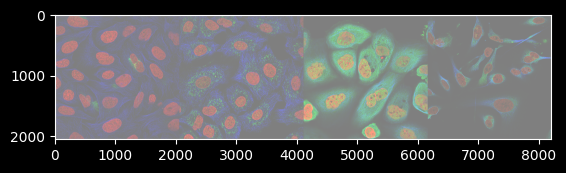

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0.]) tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.]) tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


In [6]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]}' for j in range(batch_size)))

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 509 * 509, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 19)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [8]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=4145296, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=19, bias=True)
)


In [9]:
# import torchvision.models as models
# net = models.resnet50(weights='ResNet50_Weights.DEFAULT', progress = False)

In [10]:
import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        batch_calculation = 5
        if i % 5 == 4:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / batch_calculation:.3f}')
            running_loss = 0.0

print('Finished Training')

0it [00:00, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


5it [00:45,  8.21s/it]

[1,     5] loss: 0.685


10it [01:21,  7.41s/it]

[1,    10] loss: 0.627


15it [01:58,  7.41s/it]

[1,    15] loss: 0.536


20it [02:36,  7.46s/it]

[1,    20] loss: 0.423


25it [03:11,  7.00s/it]

[1,    25] loss: 0.340


25it [03:31,  8.45s/it]
0it [00:00, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



5it [00:42,  7.56s/it]

[2,     5] loss: 0.258


10it [01:17,  7.18s/it]

[2,    10] loss: 0.268


15it [01:52,  7.09s/it]

[2,    15] loss: 0.270


20it [02:28,  7.28s/it]

[2,    20] loss: 0.284


25it [03:07,  7.53s/it]

[2,    25] loss: 0.267


25it [03:27,  8.30s/it]

Finished Training


In [12]:
checkpoint_dir = Path('./checkpoints/net.pth')
checkpoint_dir.parent.mkdir(parents=True, exist_ok=True)
torch.save(net.state_dict(), checkpoint_dir)

In [13]:
# dataiter = iter(testloader)
# images, labels = next(dataiter)
# 
# # print images
# imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))